# Exploration

In [1]:
import pandas as pd

Dementia = pd.read_csv("dementia_dataset.csv")

In [2]:
Dementia.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [3]:
data = Dementia.copy()
data.rename(columns = {"M/F":"Gender"}, inplace = True)
data["Gender"].replace(to_replace = {"M":0, "F":1}, inplace = True)
data["Hand"].replace(to_replace = {"R":0, "L":1}, inplace = True)

In [4]:
first = data[data["Visit"]==1]

In [5]:
data[data["MMSE"].isna()]

,Subject ID,MRI ID,Group,Visit,MR Delay,Gender,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
357,OAS2_0181,OAS2_0181_MR2,Demented,2,539,1,0,75,12,NaN,NaN,1.0,1169,0.742,1.501
358,OAS2_0181,OAS2_0181_MR3,Demented,3,1107,1,0,77,12,NaN,NaN,1.0,1159,0.733,1.515


In [6]:
data["MMSE"][357] = data["MMSE"][356]
data["MMSE"][358] = data["MMSE"][356]

C:\Users\brett\AppData\Local\Temp\ipykernel_9672\769730603.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["MMSE"][357] = data["MMSE"][356]
C:\Users\brett\AppData\Local\Temp\ipykernel_9672\769730603.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["MMSE"][358] = data["MMSE"][356]


In [7]:
frame = first[first["SES"].isna()]["SES"]
med = first[~first["SES"].isna() & first["Visit"]==1]["SES"].median()
for i in frame.index: 
    first["SES"][i] = med

first.drop(["Visit", "MR Delay"], inplace = True, axis = 1)

C:\Users\brett\AppData\Local\Temp\ipykernel_9672\3219345145.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first["SES"][i] = med
C:\Users\brett\AppData\Local\Temp\ipykernel_9672\3219345145.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first.drop(["Visit", "MR Delay"], inplace = True, axis = 1)


# Univariate Analysis

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


Age
Skew: 0.19


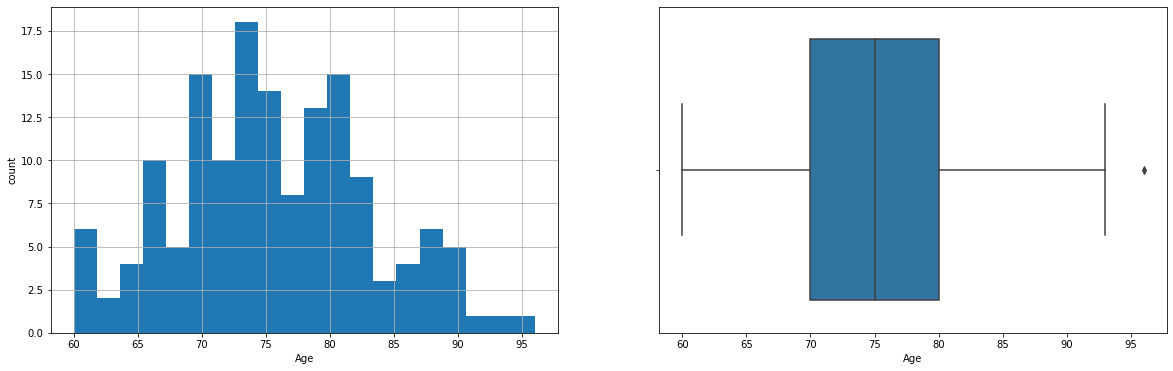

EDUC
Skew: -0.01


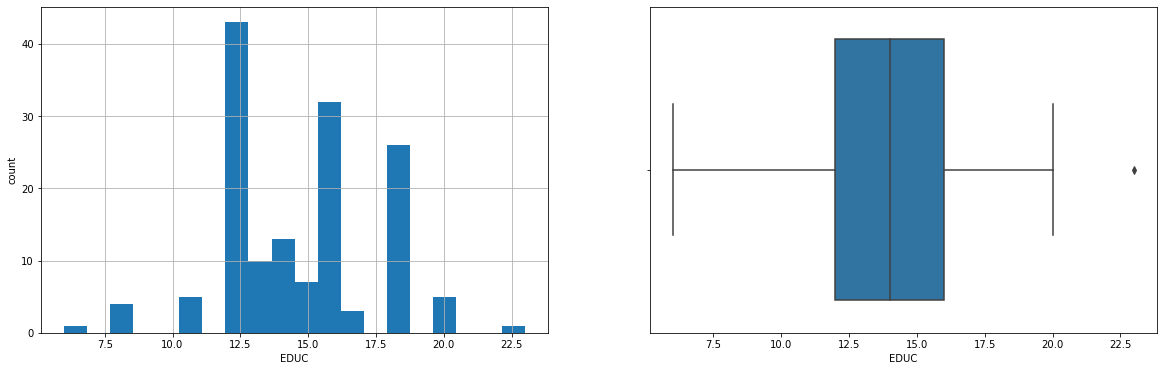

MMSE
Skew: -1.47


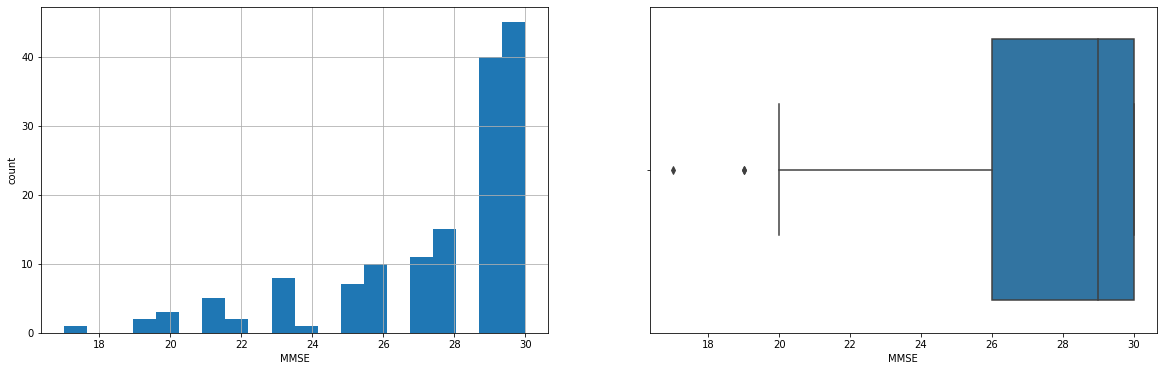

eTIV
Skew: 0.63


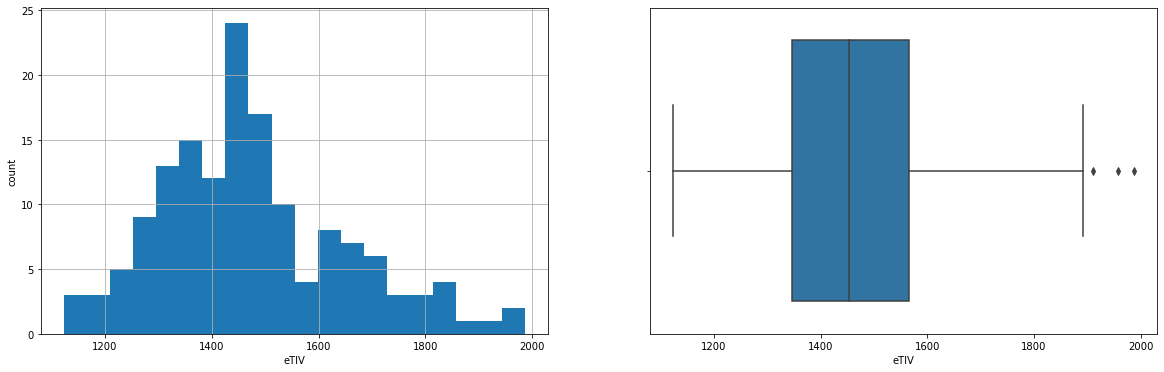

nWBV
Skew: 0.27


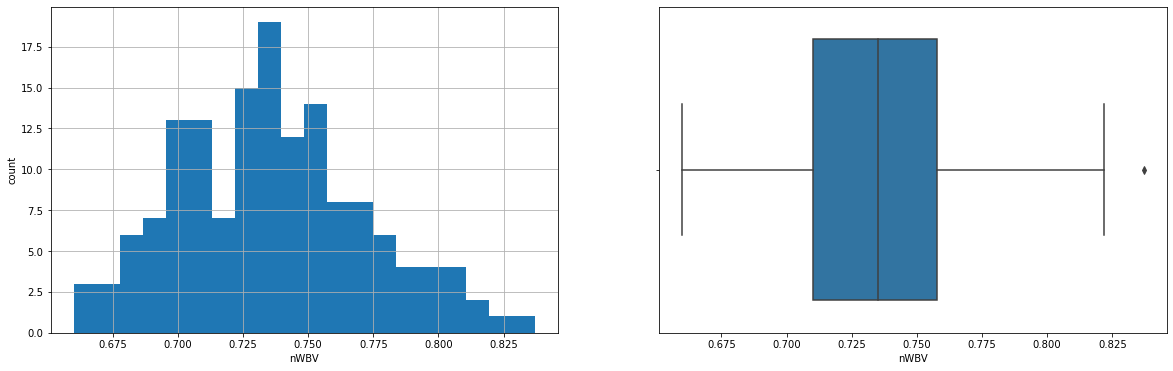

ASF
Skew: -0.0


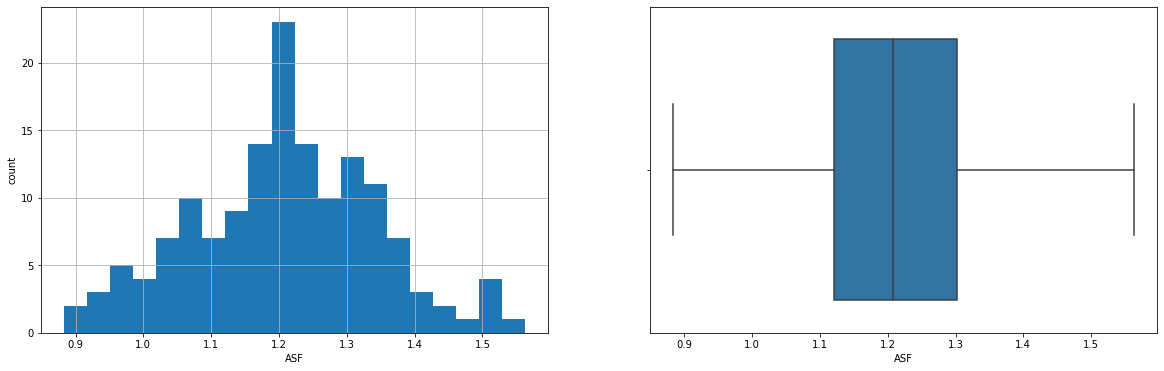

In [9]:
for col in ['Age','EDUC','MMSE','eTIV', 'nWBV', 'ASF']: 
    print(col)
    print(f'Skew: {round(first[col].skew(),2)}')
    plt.figure(figsize = (20,6))
    plt.subplot(1,2,1)
    first[col].hist(bins = 20)
    plt.ylabel("count")
    plt.xlabel(col)
    plt.subplot(1,2,2)
    sns.boxplot(x = first[col])
    plt.show()

* MMSE (Mini Mental State Examination) skewed left since the nondemented people will do well on this (half the dataset). More than half have a score of 29+
* For other features, we would expect to see roughly normal curves, but we have only 150 patients, so the skews are not surprising. 

# Bivariate Analysis

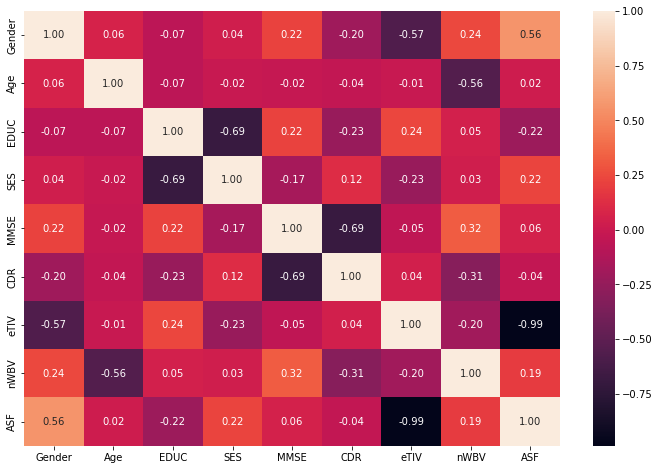

In [10]:
plt.figure(figsize = (12,8))
sns.heatmap(data = first.drop(["Hand"], axis = 1).corr(), annot = True, fmt = '.2f')
plt.show()

* 1-1 correlation with eTIV and ASF.  ASF is used to help find the estimate eTIV
* men have higher eTIV. 
* I don't have a metric for how socioeconomic status (SES) is measured. It looks like a lower number, the higher the class. At least that would make sense with respect to the relationship between SES and EDUC.  More education means higher status. 

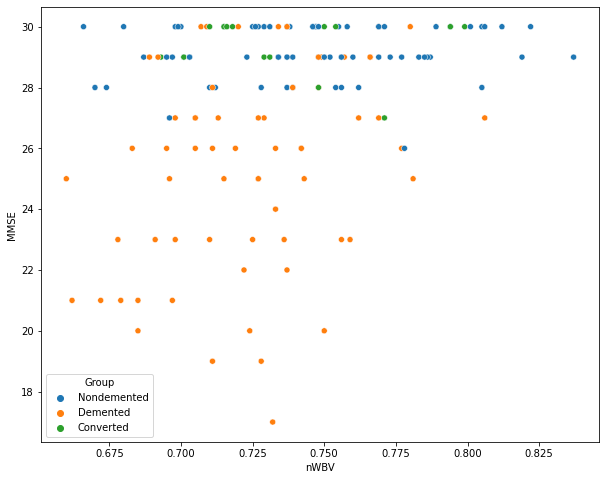

In [11]:
# I want a closer look at the nWBV and MMSE and how they are related with respect to the group. 

plt.figure(figsize = (10,8))
sns.scatterplot(data = first, y = "MMSE", x = "nWBV", hue = "Group")
plt.show()


# Models

In [12]:
import sklearn
from sklearn.metrics import confusion_matrix, classification_report, recall_score
from sklearn import metrics

#modified code from Data Science Online Courses. 
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize = (8,5))
    sns.heatmap(data = cm, annot = True, fmt = '.2f', xticklabels = ['Not Demented', 'Demented'], yticklabels = ['Not Demented', 'Demented'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [13]:
first.head()

,Subject ID,MRI ID,Group,Gender,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,0,0,87,14,2.0,27.0,0.0,1987,0.696,0.883
2,OAS2_0002,OAS2_0002_MR1,Demented,0,0,75,12,2.0,23.0,0.5,1678,0.736,1.046
5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,88,18,3.0,28.0,0.0,1215,0.710,1.444
7,OAS2_0005,OAS2_0005_MR1,Nondemented,0,0,80,12,4.0,28.0,0.0,1689,0.712,1.039
10,OAS2_0007,OAS2_0007_MR1,Demented,0,0,71,16,2.0,28.0,0.5,1357,0.748,1.293


In [14]:
# Drop id columns and convert group to binary. (converted will act as demented since that is how they end up)
first["Group"] = first["Group"].replace({"Nondemented":0, "Demented":1, "Converted":0})
first.drop(["Subject ID", "MRI ID", "Hand"], inplace = True, axis = 1)

C:\Users\brett\AppData\Local\Temp\ipykernel_9672\2925192211.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first["Group"] = first["Group"].replace({"Nondemented":0, "Demented":1, "Converted":0})
C:\Users\brett\AppData\Local\Temp\ipykernel_9672\2925192211.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first.drop(["Subject ID", "MRI ID", "Hand"], inplace = True, axis = 1)


### Decision Tree

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

G = first["Group"]
X = first.drop(["Group"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, G, test_size = .25, random_state = 1)

In [16]:
d_tree = DecisionTreeClassifier()
d_tree.fit(X_train, y_train)

DecisionTreeClassifier()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        63
           1       1.00      1.00      1.00        49

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112



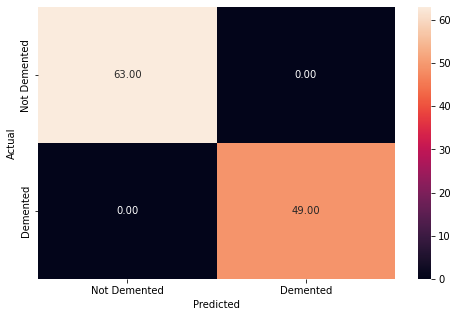

In [17]:
# Accuracy on training set
y_pred_train = d_tree.predict(X_train)
metrics_score(y_train, y_pred_train)

* This is expected, and certainly overfit. 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        15

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



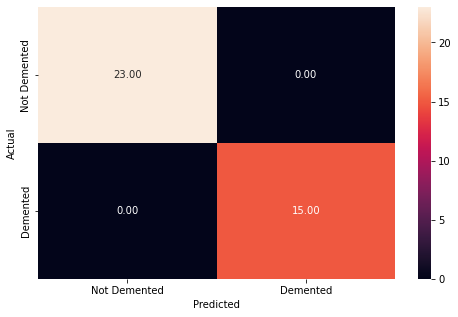

In [18]:
# accuracy on test set
y_pred_test = d_tree.predict(X_test)
metrics_score(y_test, y_pred_test)

* Not terrible.  However, the data that is collected here is the same patients used multiple times. 
* I think what is happening is that the test set consists of patients that the model is trained on.  Therefore, matching features of the same patients, and thus boosting the accuracy rating. 

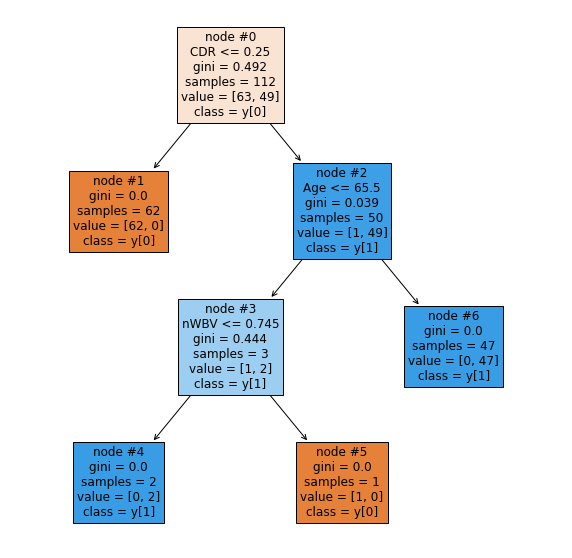

In [19]:
feat = list(X.columns)

plt.figure(figsize = (10,10))
tree.plot_tree(d_tree, feature_names = feat, filled = True, node_ids = True, class_names = True, fontsize = 12)
plt.show()

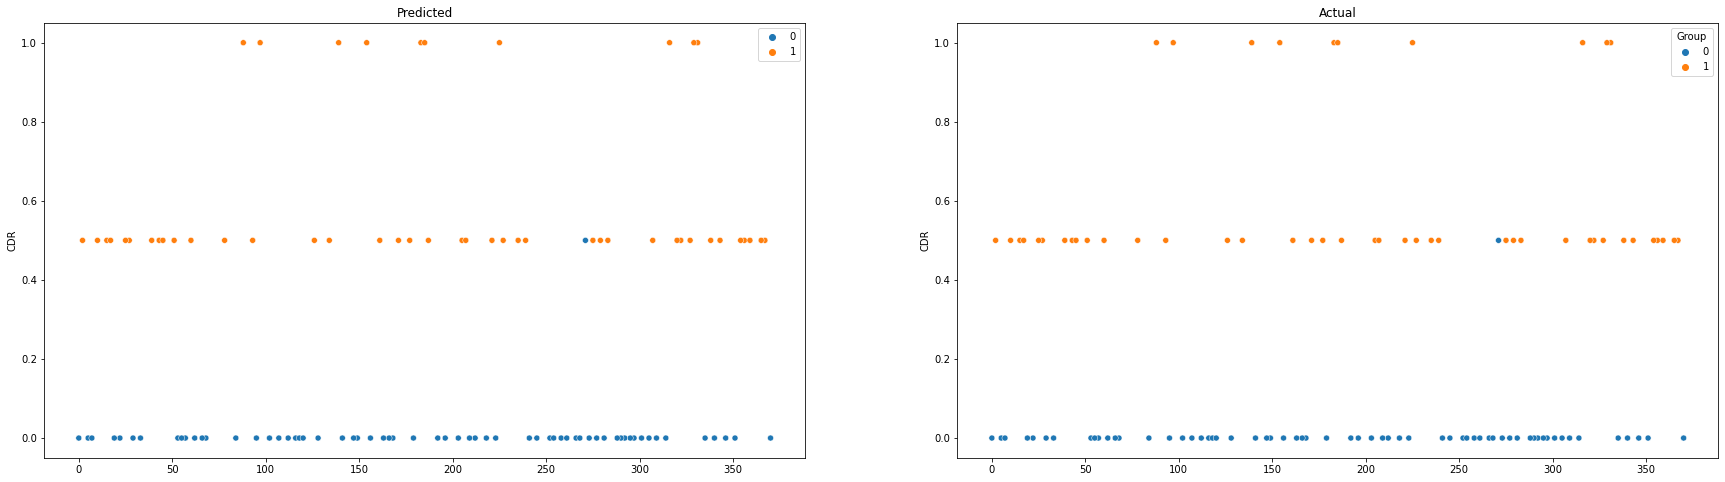

In [20]:
plt.figure(figsize = (30,8))
plt.subplot(1,2,1)
sns.scatterplot(x = X_train.index, y = X_train["CDR"], hue = y_pred_train).set_title("Predicted")
plt.subplot(1,2,2)
sns.scatterplot(x = X_train.index, y = X_train["CDR"], hue = y_train).set_title("Actual")
plt.show()

In [21]:
from sklearn.model_selection import GridSearchCV

# try to prune the tree, so that it fits information for a broader population than these sets. 
d_tree_tune = DecisionTreeClassifier(random_state = 1, class_weight = "balanced")

parameters = {'max_depth': np.arange(2,5), 
              'criterion':['gini', 'entropy'], 
              'min_samples_leaf':[5,7,9,11,13,15]}

grid_obj = GridSearchCV(d_tree_tune, parameters, scoring = "accuracy", cv = 5)
grid_obj = grid_obj.fit(X_train, y_train)

d_tree_tuned = grid_obj.best_estimator_
d_tree_tuned.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=2, min_samples_leaf=5,
                       random_state=1)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        63
           1       0.98      1.00      0.99        49

    accuracy                           0.99       112
   macro avg       0.99      0.99      0.99       112
weighted avg       0.99      0.99      0.99       112



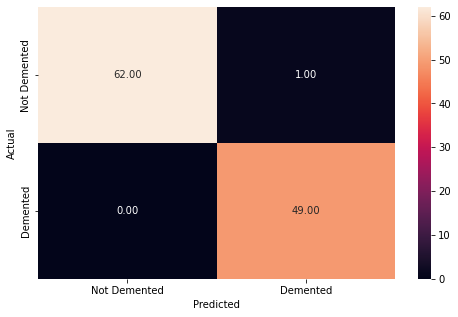

In [22]:
y_pred_train = d_tree_tuned.predict(X_train)
metrics_score(y_train, y_pred_train)

* There aren't many data points, so extending this beyond this dataset would be unadvised. 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        15

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



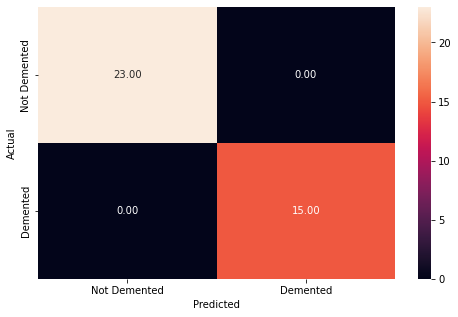

In [23]:
y_pred_test = d_tree_tuned.predict(X_test)
metrics_score(y_test, y_pred_test)

* same results as the training set. 
* The first visit set may not have any points with a CDR of 0 and a group label of demented. 

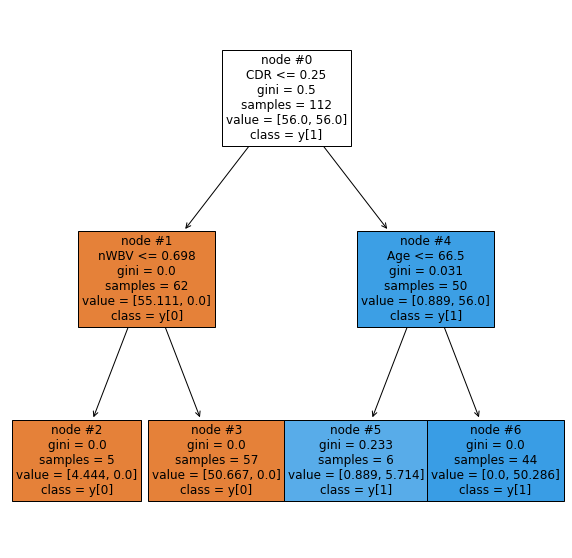

In [24]:
feat = list(X_train.columns)

plt.figure(figsize = (10,10))
tree.plot_tree(d_tree_tuned, feature_names = feat, filled = True, node_ids = True, class_names = True, fontsize = 12)
plt.show()

* The model is separating based on CDR first. 
* We see the one mislabel is of a patient with a CDR of .5, and nondemented status. 
* I think the biggest problem with this set is the lack of data points. 

### Random Forest Ensemble

In [25]:
rf = RandomForestClassifier(class_weight = "balanced")

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        63
           1       1.00      1.00      1.00        49

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112



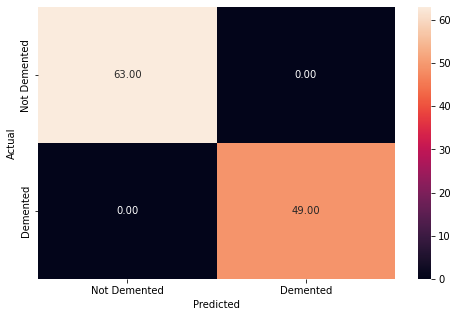

In [26]:
y_pred_train = rf.predict(X_train)
metrics_score(y_train, y_pred_train)

* My concerns about the size of the data set remain. 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        15

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



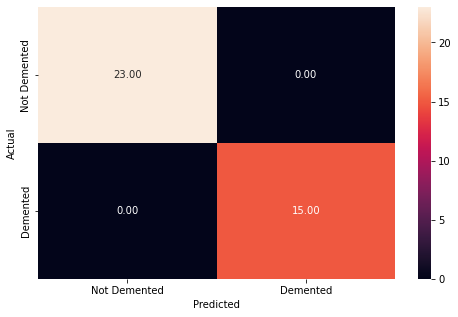

In [27]:
y_pred_test = rf.predict(X_test)
metrics_score(y_test, y_pred_test)

In [28]:
# tune the random forest

rf_tuned = RandomForestClassifier(class_weight = "balanced", random_state = 1)

parameters = {"n_estimators": [5,10,15,20,25,30],
              "max_depth": [4,5,6,7],
              "max_features":[.9,1],
              "criterion": ["gini","entropy"], 
              "min_samples_leaf":[1,2,3]}

grid = GridSearchCV(rf_tuned, parameters, scoring = "accuracy", cv = 5)
grid = grid.fit(X_train, y_train)

rf_tuned = grid.best_estimator_
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, max_features=1, min_samples_leaf=2,
                       n_estimators=15, random_state=1)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        63
           1       0.96      1.00      0.98        49

    accuracy                           0.98       112
   macro avg       0.98      0.98      0.98       112
weighted avg       0.98      0.98      0.98       112



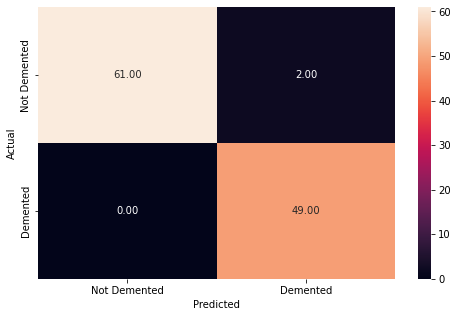

In [29]:
y_pred_train = rf_tuned.predict(X_train)
metrics_score(y_train, y_pred_train)

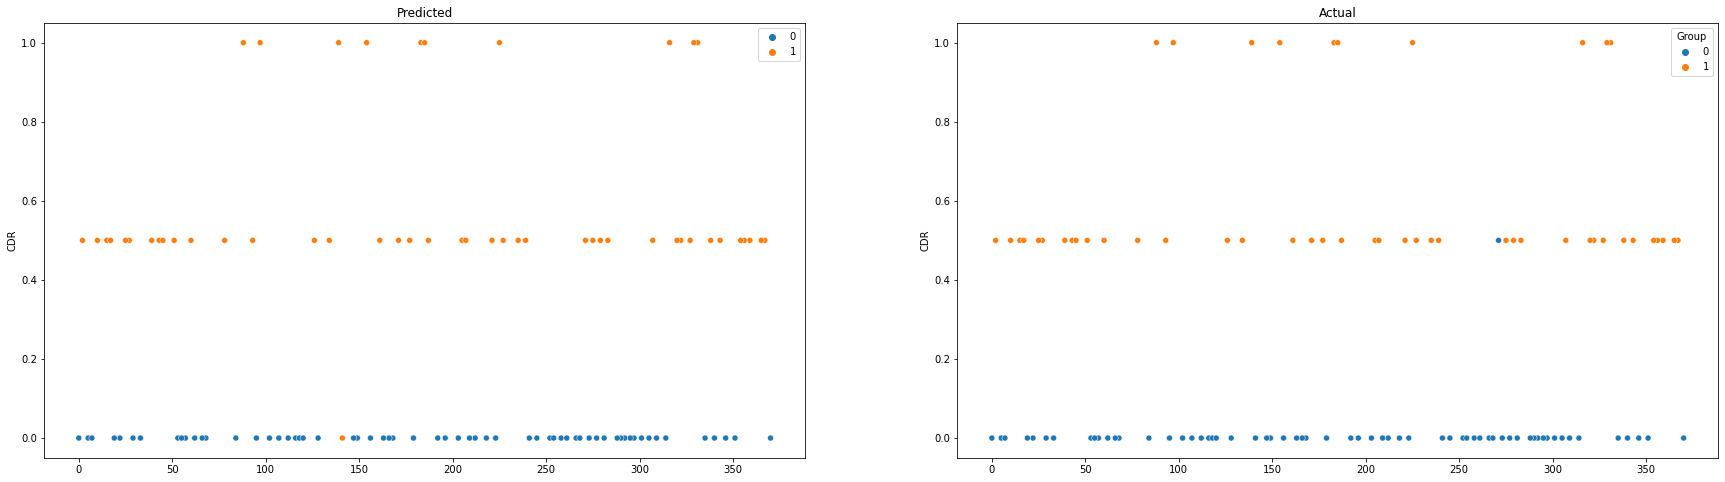

In [30]:
plt.figure(figsize = (30,8))
plt.subplot(1,2,1)
sns.scatterplot(x = X_train.index, y = X_train["CDR"], hue = y_pred_train).set_title("Predicted")
plt.subplot(1,2,2)
sns.scatterplot(x = X_train.index, y = X_train["CDR"], hue = y_train).set_title("Actual")
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        15

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



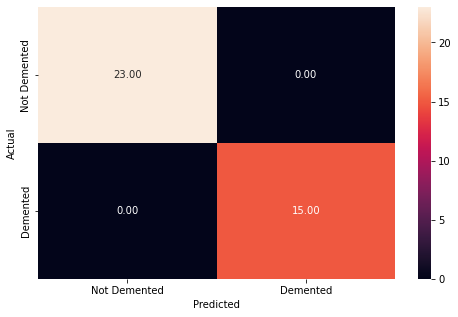

In [31]:
y_pred_test = rf_tuned.predict(X_test)
metrics_score(y_test, y_pred_test)

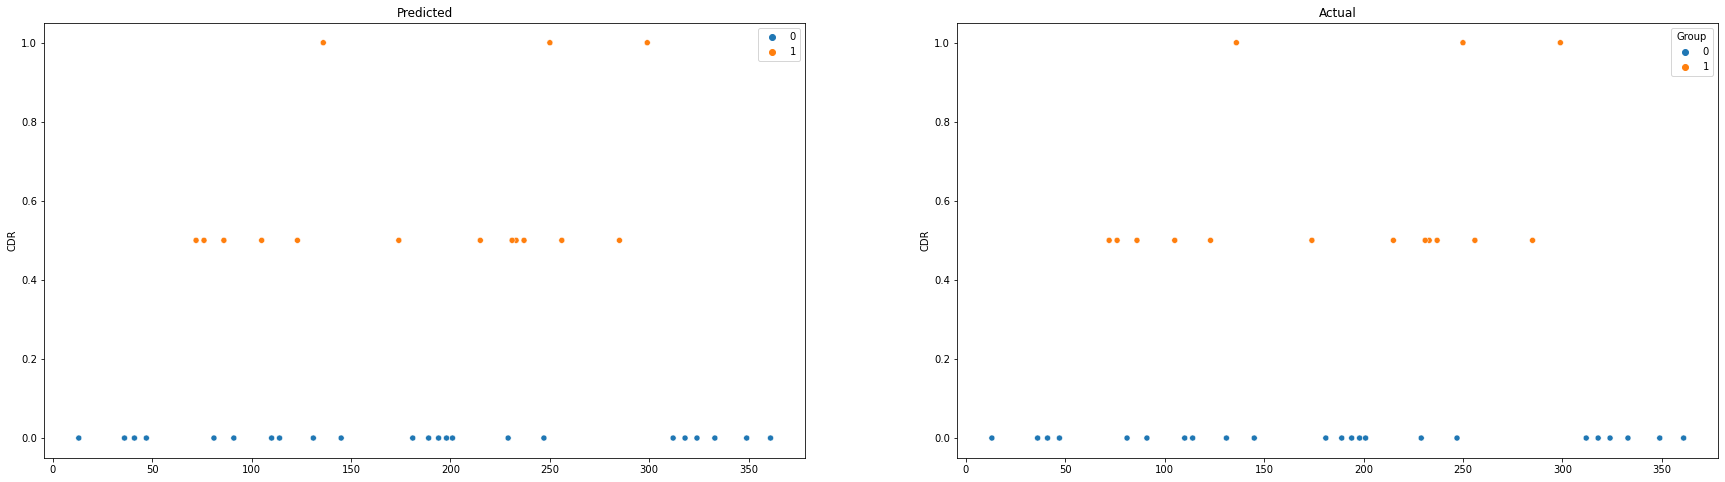

In [32]:
plt.figure(figsize = (30,8))
plt.subplot(1,2,1)
sns.scatterplot(x = X_test.index, y = X_test["CDR"], hue = y_pred_test).set_title("Predicted")
plt.subplot(1,2,2)
sns.scatterplot(x = X_test.index, y = X_test["CDR"], hue = y_test).set_title("Actual")
plt.show()

### Notes on dataset
* With respect to the dataset limited to the first visit, there aren't enough data points to be able to come away with any meaningful data. 
* The whole dataset weights patients differently based on how many visits they had. 
* This process would be more meaningful if the data didn't have a "converted" status. 